# Step 1:  Data Cleaning



In [1]:
# Load NLTK resources (required only once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/apatecpetschnig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/apatecpetschnig/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
#load the data in 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump, load
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
import numpy as np

# Load data
df_promoting = pd.read_csv("data_promoting_eating_disorders.csv")
df_neutral = pd.read_csv("neutral_data.csv")

In [3]:
# Merge datasets
df = pd.concat([df_promoting, df_neutral], ignore_index=True)

In [4]:
df.head()

,Content,Origin,Eating_Disorder,Type,Method
0,"""I wish I had the willpower to starve myself l...",mixtral,1,Comment,Generated
1,"""Skinny is always going to be in, and fat is a...",mixtral,1,Comment,Generated
2,"""I can't even look at food without feeling gui...",mixtral,1,Comment,Generated
3,"""I'm on a strict diet, only eating 500 calorie...",mixtral,1,Comment,Generated
4,"""I don't know how she stays so thin, she must ...",mixtral,1,Comment,Generated


In [5]:
# Load internet_data.csv with ';' as the delimiter
# Specify usecols to only load the columns that exist in df
internet_data = pd.read_csv("internet_data.csv", delimiter=';', usecols=df.columns)

# Merge the newly loaded internet_data with the existing DataFrame df
df = pd.concat([df, internet_data], ignore_index=True)

## Delete duplicates

We will delete duplicates in case there a couple of them in the training data.

In [6]:
# Remove duplicates based on the 'Content' column
df = df.drop_duplicates(subset=['Content'])

## Deleting NaNs

We also delete rows in case they have "NaNs" in the content field

In [7]:
# Remove rows where 'Content' is NaN
df = df.dropna(subset=['Content'])
contents = df['Content'].values

## The distribution of data

We can see below that we have a nearly even data between training data that is classified as content that leads to an eating disorder and data that is not classified as content that that leads to an eating disorder.

In [8]:
# Count how many social media posts are classified as 0 and 1
class_counts = df['Eating_Disorder'].value_counts()
print("Counts of social media posts by classification:")
print(class_counts)

Counts of social media posts by classification:
Eating_Disorder
0.0    1065
1.0    1039
Name: count, dtype: int64


In [9]:
df.head()

,Content,Origin,Eating_Disorder,Type,Method
0,"""I wish I had the willpower to starve myself l...",mixtral,1.0,Comment,Generated
1,"""Skinny is always going to be in, and fat is a...",mixtral,1.0,Comment,Generated
2,"""I can't even look at food without feeling gui...",mixtral,1.0,Comment,Generated
3,"""I'm on a strict diet, only eating 500 calorie...",mixtral,1.0,Comment,Generated
4,"""I don't know how she stays so thin, she must ...",mixtral,1.0,Comment,Generated


# Step 2: Data Pre-Processing

This preprocessing function performs a series of text processing steps on the training data:

1. **Ensure String Format**: The function first ensures that the input text is in string format. This is crucial because the subsequent processing steps require the input to be in text form, and this ensures compatibility regardless of the initial data type.

2. **Tokenization**: This step involves breaking down the text into individual words or tokens. It’s a fundamental step in text preprocessing, allowing for the analysis of individual words within the context of the whole text.

3. **Stopword Removal**: Common words like "and", "the", and "in", known as stopwords, are usually irrelevant for analysis and can be removed. This step eliminates them, focusing the analysis on more meaningful words. This reduces the dataset size and potentially improves the model's performance by focusing on informative words.

4. **Stemming**: It is a technique to reduce words to their root form. Stemming cuts off prefixes and suffixes. This specific implementation uses stemming to normalize words (for example, "running" becomes "run"). This helps in generalizing different forms of the same word, allowing the model to learn from the base meaning rather than treating each form as a separate entity.

5. **Reconversion to Text**: After the tokens have been processed, they are joined back into a single string. This is necessary because most machine learning models expect the input as a sequence or collection of texts rather than isolated tokens.

#### Why It's Good Before Training a Classification Model

- **Noise Reduction**: By removing stopwords and non-relevant components, the model can focus on significant features, reducing noise and potentially increasing accuracy.
  
- **Dimensionality Reduction**: Stemming/lemmatization and stopword removal decrease the number of unique words in the dataset. This simplifies the model’s feature space, which can lead to faster training times and reduce the risk of overfitting.
  
- **Normalization**: Bringing words to their base form means similar meanings are treated the same regardless of grammatical differences, improving model consistency and interpretability.

- **Improved Performance**: Overall, these preprocessing steps make the text more uniform and focused on the content that carries meaning, which can lead to improved model performance on tasks like classification.

In [10]:
# Preprocessing function
def preprocess_text(text):
    # Ensure that the input is a string
    text = str(text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Stopword removal
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Re-convert to text
    return " ".join(tokens)

# Apply preprocessing to each row
df['Content_preprocessed'] = df['Content'].apply(lambda x: preprocess_text(str(x).lower()))

# Display the first few rows of the processed DataFrame
print(df.head())

                                             Content   Origin  \
0  "I wish I had the willpower to starve myself l...  mixtral   
1  "Skinny is always going to be in, and fat is a...  mixtral   
2  "I can't even look at food without feeling gui...  mixtral   
3  "I'm on a strict diet, only eating 500 calorie...  mixtral   
4  "I don't know how she stays so thin, she must ...  mixtral   

   Eating_Disorder     Type     Method  \
0              1.0  Comment  Generated   
1              1.0  Comment  Generated   
2              1.0  Comment  Generated   
3              1.0  Comment  Generated   
4              1.0  Comment  Generated   

                                Content_preprocessed  
0                    `` wish willpow starv like . ''  
1       `` skinni alway go , fat four-lett word . ''  
2  `` ca n't even look food without feel guilti . ''  
3        `` 'm strict diet , eat 500 calori day . ''  
4       `` n't know stay thin , must eat disord . ''  


# Step 3: Feature extraction

Given the context of classifying social media posts related to eating disorders, choosing the right approach for feature extraction requires considering the specific nuances of the task. For this purpose, Term Frequency-Inverse Document Frequency (TF-IDF) could be highly effective and is the approach I recommend.

### Why TF-IDF for this case?

**1. Semantic Importance:** TF-IDF gives importance to words according to how uniquely they can identify a category. In the context of eating disorders, certain phrases or expressions might be particularly indicative of harmful content or a neutral stance. TF-IDF will automatically assign higher weights to these terms, making the model more sensitive to the nuances of language in this context.

**2. Simplicity and Efficiency:** While advanced techniques like Word2Vec or GloVe offer rich semantic embeddings, they also introduce complexity and may require a larger dataset to effectively learn the contextual relationships between words. Given the sensitive nature of the task and potential limitations on data volume, TF-IDF's simpler statistical approach provides an efficient balance between capturing semantic importance and practicality. It's relatively easy to implement and understand, which is crucial for tasks requiring a transparent and interpretable model.

**3. Dimensionality Reduction:** TF-IDF can help in reducing the dimensionality of the feature set. By focusing on the words that are most descriptive (high TF-IDF scores) and discarding those that occur too frequently across all categories (low TF-IDF scores) or are too rare, it helps in keeping the model focused and manageable.

**4. Relevance to Text Classification:** TF-IDF has been proven to be highly effective for text classification tasks. Since our goal is to classify social media posts into categories related to eating disorders, leveraging a technique that excels in identifying distinguishing features in texts aligns well with our objectives.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

contents = df['Content'].values

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Fit and transform the contents to create a feature matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(contents)

Now, `tfidf_matrix` is ready to be used as input for training models

In [12]:
# Get the feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the DataFrame
print(tfidf_df.head())

# Having a look at the TF-IDF values
print(tfidf_df.iloc[0])

    10  100   11   12   13   14   15   16   17   18  ...  worthy  wow   xs  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0  0.0  0.0   

   year  yes  yesterday  yoga  yogurt  zero  zip  
0   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
1   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
2   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
3   0.0  0.0        0.0   0.0     0.0   0.0  0.0  
4   0.0  0.0        0.0   0.0     0.0   0.0  0.0  

[5 rows x 1000 columns]
10           0.0
100          0.0
11           0.0
12           0.0
13           0.0
            ... 
yesterday    0.0
yoga         0.0
yogurt       0.0
zero         0.0
zip          0.0
Name: 0, Leng

# Step 4: Exploratory data analysis

### Visualizing the istribution of classes

/var/folders/hd/n1358vbn09v5xngb1gmpdwvw0000gp/T/ipykernel_938/501842797.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


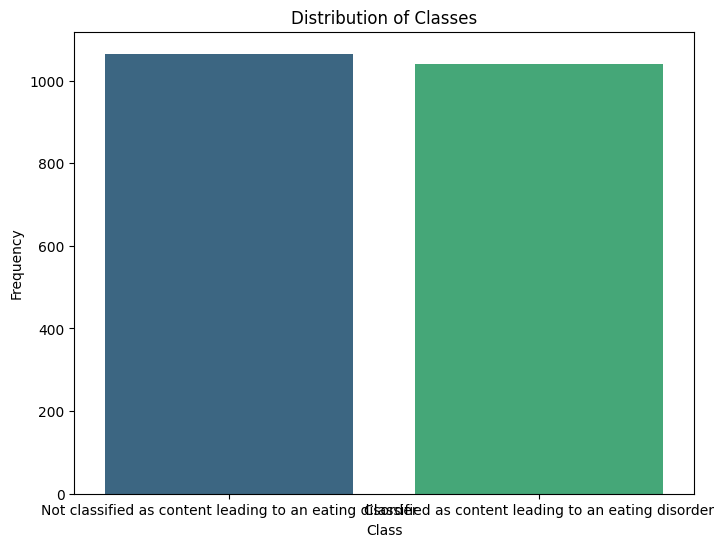

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class_distribution = df['Eating_Disorder'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(len(class_distribution.index)), ['Not classified as content leading to an eating disorder', 'Classified as content leading to an eating disorder'])
plt.show()

## Plotting the most frequent terms

Knowing the most frequent terms in each category helps in understanding the textual patterns that might differentiate between classes. This can inform pre-processing, feature selection, and even provide insights for refining the model.

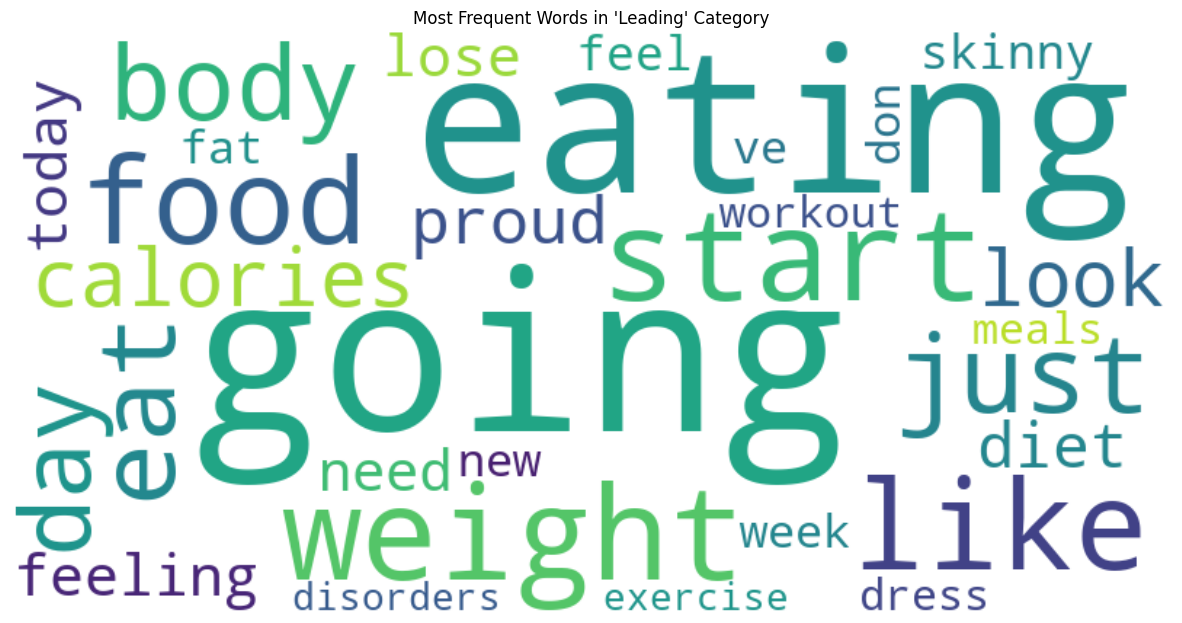

In [14]:
#identifying important terms 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Function to plot most frequent terms
def plot_most_frequent_words(texts, title="Most Frequent Words", ngram_range=(1,1), max_words=30):
    # Using CountVectorizer to find ngrams
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    bag_of_words = vectorizer.fit_transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:max_words]
    words_dict = dict(words_freq)
    
    # Generating word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words_dict)
    
    # Plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plotting for 'leading to eating disorders'
leading_texts = df[df['Eating_Disorder'] == 1]['Content']
plot_most_frequent_words(leading_texts, title="Most Frequent Words in 'Leading' Category")


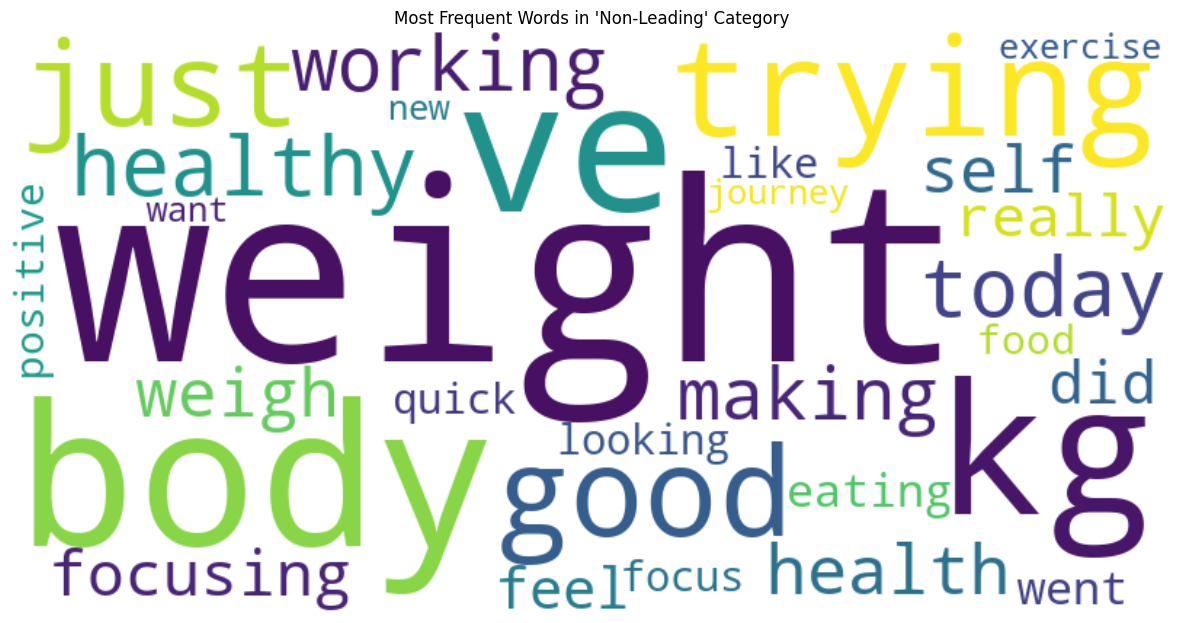

In [15]:
# Plotting for 'non-leading to eating disorders'
non_leading_texts = df[df['Eating_Disorder'] == 0]['Content']
plot_most_frequent_words(non_leading_texts, title="Most Frequent Words in 'Non-Leading' Category")

# Step 5: Model selection, training & evaluation of each model

We will split the data into training and testing sets, experiment with a few classifiers, perform cross-validation, and train the model.

## Model Selection 

We'll try out multiple classifiers and see how they perform. Let's start with a simple model like Naive Bayes and then try a more complex one like Random Forest.

**Why These Models?**
- **Naive Bayes:** It’s simple, fast, and often works well for text classification tasks, especially as a baseline.
- **Random Forest:** It’s a robust model that can handle both linear and non-linear relationships. This model might capture more complex patterns in the data.

## Evaluation

The code above also includes evaluation steps using `classification_report` and `confusion_matrix`, which will provide metrics like accuracy, precision, recall, and F1-score for each model. These metrics are essential to understand how well a model performs. Here’s why we use each one:

- **Accuracy:** Gives us the overall accuracy of the model.
- **Precision:** Indicates the proportion of positive identifications that were actually correct, which is crucial if the cost of false positives is high.
- **Recall (Sensitivity):** Indicates the proportion of actual positives that were identified correctly, crucial when it’s important to capture as many positives as possible.
- **F1-Score:** Provides a balance between Precision and Recall. It’s useful when we need a balance between detecting positives and avoiding false positives.

## Cross-Validation

### Why doing that?:

- **Performance Estimation:** Provides a more accurate measure of the model's performance compared to a single train-test split, especially with limited data.
- **Robustness:** Helps in identifying not just how well a model performs on average but also how its performance varies across different subsets of data. This variation is captured by looking at the standard deviation of the scores across folds.
- **Overfitting Detection:** By testing the model on different subsets of data, cross-validation can help in detecting overfitting. A model that performs exceptionally well on the training data but poorly on the validation folds is likely overfitting.

## Split Data into train and test data

In [ ]:
X = tfidf_matrix  # Features from TF-IDF
y = df['Eating_Disorder'].values  # Target variable

# Split the data - 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Naive Bayes Algorithm

In [17]:
# Assuming the data preprocessing steps here to define X_train, y_train, X_test, and y_test
def train_eval_naive_bayes(X_train, y_train, X_test, y_test):
    # Naive Bayes classifier instantiated outside this function is used here
    global nb_classifier
    nb_classifier.fit(X_train, y_train)
    
    # Prediction on test data
    y_pred = nb_classifier.predict(X_test)
    
    # Model Evaluation
    print("Naive Bayes Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Initialize Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train and evaluate Naive Bayes
print("Naive Bayes Model Training and Evaluation:")
train_eval_naive_bayes(X_train, y_train, X_test, y_test)

# Cross-validation for Naive Bayes
nb_scores = cross_val_score(nb_classifier, X, y, cv=5, scoring='accuracy')
print(f'Naive Bayes - Accuracy across 5 folds:', nb_scores)
print(f'Naive Bayes - Average Accuracy: {np.mean(nb_scores):.4f}')
print(f'Naive Bayes - Standard Deviation: {np.std(nb_scores):.4f}\n')

# Save Naive Bayes Model
dump(nb_classifier, 'naive_bayes_model.joblib')

Naive Bayes Model Training and Evaluation:
Naive Bayes Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       208
         1.0       0.96      0.95      0.96       213

    accuracy                           0.95       421
   macro avg       0.95      0.95      0.95       421
weighted avg       0.95      0.95      0.95       421

Confusion Matrix:
 [[199   9]
 [ 10 203]]
Naive Bayes - Accuracy across 5 folds: [0.84085511 0.79809976 0.85035629 0.83610451 0.80238095]
Naive Bayes - Average Accuracy: 0.8256
Naive Bayes - Standard Deviation: 0.0212



['naive_bayes_model.joblib']

## Random forest algorithm 

In [20]:
def train_eval_random_forest(X_train, y_train, X_test, y_test):
    # Instantiate the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the Random Forest model
    rf_classifier.fit(X_train, y_train)
    
    # Prediction on test data
    y_pred = rf_classifier.predict(X_test)
    
    # Model Evaluation
    print("Random Forest Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return rf_classifier  # Return the trained model

# Train and evaluate Random Forest Model
print("Random Forest Model Training and Evaluation:")
rf_model = train_eval_random_forest(X_train, y_train, X_test, y_test)

# Cross-validation for Random Forest
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f'Random Forest - Accuracy across 5 folds:', rf_scores)
print(f'Random Forest - Average Accuracy: {np.mean(rf_scores):.4f}')
print(f'Random Forest - Standard Deviation: {np.std(rf_scores):.4f}\n')

# Save Random Forest Model
dump(rf_model, 'random_forest_model.joblib')

Random Forest Model Training and Evaluation:
Random Forest Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       208
         1.0       0.91      0.94      0.93       213

    accuracy                           0.92       421
   macro avg       0.92      0.92      0.92       421
weighted avg       0.92      0.92      0.92       421

Confusion Matrix:
 [[188  20]
 [ 12 201]]
Random Forest - Accuracy across 5 folds: [0.80760095 0.78622328 0.79809976 0.81947743 0.74047619]
Random Forest - Average Accuracy: 0.7904
Random Forest - Standard Deviation: 0.0272



['random_forest_model.joblib']

## Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump
import numpy as np

def train_eval_logistic_regression(X_train, y_train, X_test, y_test):
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)

    print("Logistic Regression Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return lr_model


lr_model = train_eval_logistic_regression(X_train, y_train, X_test, y_test)

# Cross-validation for Logistic Regression
lr_scores = cross_val_score(lr_model, X, y, cv=5, scoring='accuracy')
print(f'Logistic Regression - Accuracy across 5 folds:', lr_scores)
print(f'Logistic Regression - Average Accuracy: {np.mean(lr_scores):.4f}')
print(f'Logistic Regression - Standard Deviation: {np.std(lr_scores):.4f}')

# Save Logistic Regression Model
dump(lr_model, 'logistic_regression_model.joblib')

Logistic Regression Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       208
         1.0       0.95      0.92      0.94       213

    accuracy                           0.94       421
   macro avg       0.94      0.94      0.94       421
weighted avg       0.94      0.94      0.94       421

Confusion Matrix:
 [[198  10]
 [ 16 197]]
Logistic Regression - Accuracy across 5 folds: [0.84085511 0.78859857 0.86698337 0.85273159 0.8       ]
Logistic Regression - Average Accuracy: 0.8298
Logistic Regression - Standard Deviation: 0.0304


['logistic_regression_model.joblib']

## Support Vector Machine

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump
import numpy as np

def train_eval_svm(X_train, y_train, X_test, y_test, kernel='linear'):
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    print(f"SVM ({kernel} kernel) Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return svm_classifier


svm_model = train_eval_svm(X_train, y_train, X_test, y_test, kernel='linear')

# Cross-validation for SVM
svm_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
print(f'SVM - Accuracy across 5 folds:', svm_scores)
print(f'SVM - Average Accuracy: {np.mean(svm_scores):.4f}')
print(f'SVM - Standard Deviation: {np.std(svm_scores):.4f}')

# Save SVM Model
dump(svm_model, 'svm_model.joblib')

SVM (linear kernel) Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       208
         1.0       0.94      0.94      0.94       213

    accuracy                           0.94       421
   macro avg       0.94      0.94      0.94       421
weighted avg       0.94      0.94      0.94       421

Confusion Matrix:
 [[196  12]
 [ 13 200]]
SVM - Accuracy across 5 folds: [0.82897862 0.81235154 0.86698337 0.85748219 0.80238095]
SVM - Average Accuracy: 0.8336
SVM - Standard Deviation: 0.0250


['svm_model.joblib']

## Gradient Boosting

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump
import numpy as np

def train_eval_gradient_boosting(X_train, y_train, X_test, y_test):
    gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb_classifier.fit(X_train, y_train)
    y_pred = gb_classifier.predict(X_test)

    print("Gradient Boosting Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return gb_classifier

gb_model = train_eval_gradient_boosting(X_train, y_train, X_test, y_test)

# Cross-validation for Gradient Boosting
gb_scores = cross_val_score(gb_model, X, y, cv=5, scoring='accuracy')
print(f'Gradient Boosting - Accuracy across 5 folds:', gb_scores)
print(f'Gradient Boosting - Average Accuracy: {np.mean(gb_scores):.4f}')
print(f'Gradient Boosting - Standard Deviation: {np.std(gb_scores):.4f}')

# Save Gradient Boosting Model
dump(gb_model, 'gradient_boosting_model.joblib')

Gradient Boosting Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86       208
         1.0       0.94      0.76      0.84       213

    accuracy                           0.85       421
   macro avg       0.86      0.85      0.85       421
weighted avg       0.86      0.85      0.85       421

Confusion Matrix:
 [[197  11]
 [ 52 161]]
Gradient Boosting - Accuracy across 5 folds: [0.85273159 0.83372922 0.82185273 0.76009501 0.71904762]
Gradient Boosting - Average Accuracy: 0.7975
Gradient Boosting - Standard Deviation: 0.0500


['gradient_boosting_model.joblib']

## K nearest neigbour

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump
import numpy as np

def train_eval_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)

    print("K-Nearest Neighbors Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return knn_classifier


knn_model = train_eval_knn(X_train, y_train, X_test, y_test, n_neighbors=5)

# Cross-validation for KNN
knn_scores = cross_val_score(knn_model, X, y, cv=5, scoring='accuracy')
print(f'K-Nearest Neighbors - Accuracy across 5 folds:', knn_scores)
print(f'K-Nearest Neighbors - Average Accuracy: {np.mean(knn_scores):.4f}')
print(f'K-Nearest Neighbors - Standard Deviation: {np.std(knn_scores):.4f}')

# Save KNN Model
dump(knn_model, 'knn_model.joblib')

K-Nearest Neighbors Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.96      0.21      0.35       208
         1.0       0.56      0.99      0.72       213

    accuracy                           0.61       421
   macro avg       0.76      0.60      0.53       421
weighted avg       0.76      0.61      0.53       421

Confusion Matrix:
 [[ 44 164]
 [  2 211]]
K-Nearest Neighbors - Accuracy across 5 folds: [0.54631829 0.54869359 0.5415677  0.51306413 0.78333333]
K-Nearest Neighbors - Average Accuracy: 0.5866
K-Nearest Neighbors - Standard Deviation: 0.0992


['knn_model.joblib']

## Neural network

In [25]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from joblib import dump
import numpy as np

def train_eval_mlp(X_train, y_train, X_test, y_test):
    # Initialize the MLPClassifier
    mlp_classifier = MLPClassifier(
        hidden_layer_sizes=(100,), # This is a simple network configuration; adjust as needed.
        max_iter=300,
        activation='relu',
        solver='adam',
        random_state=42
    )
    # Train the classifier
    mlp_classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = mlp_classifier.predict(X_test)
    
    # Evaluation
    print("Neural Network (MLP) Model Evaluation Results:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return mlp_classifier


mlp_model = train_eval_mlp(X_train, y_train, X_test, y_test)

# Cross-validation for MLP
mlp_scores = cross_val_score(mlp_model, X, y, cv=5, scoring='accuracy')
print(f'Neural Network (MLP) - Accuracy across 5 folds:', mlp_scores)
print(f'Neural Network (MLP) - Average Accuracy: {np.mean(mlp_scores):.4f}')
print(f'Neural Network (MLP) - Standard Deviation: {np.std(mlp_scores):.4f}')

# Save the MLP Model
dump(mlp_model, 'mlp_classifier.joblib')

Neural Network (MLP) Model Evaluation Results:
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       208
         1.0       0.93      0.94      0.93       213

    accuracy                           0.93       421
   macro avg       0.93      0.93      0.93       421
weighted avg       0.93      0.93      0.93       421

Confusion Matrix:
 [[192  16]
 [ 13 200]]
Neural Network (MLP) - Accuracy across 5 folds: [0.80997625 0.76247031 0.83135392 0.78384798 0.77380952]
Neural Network (MLP) - Average Accuracy: 0.7923
Neural Network (MLP) - Standard Deviation: 0.0251


['mlp_classifier.joblib']

## Saving the models

## Loading the models again

In [ ]:
#### Loading the Models
from joblib import load

# Loading the models in a new session (no need to retrain)
nb_classifier = load('naive_bayes_model.joblib')
rf_classifier = load('random_forest_model.joblib')

## Trying out the classifyers

In [ ]:
new_comment = ["The focus should be on eathing healthy, not being skinny"]

new_comment_vector = tfidf_vectorizer.transform(new_comment)

### Classify the New Comment

# Predict with Naive Bayes Classifier
nb_prediction = nb_classifier.predict(new_comment_vector)
print(f"Naive Bayes Prediction: {nb_prediction[0]}")  # Output will be 0 or 1

# Predict with Random Forest Classifier
rf_prediction = rf_classifier.predict(new_comment_vector)
print(f"Random Forest Prediction: {rf_prediction[0]}")  # Output will be 0 or 1

# For Naive Bayes, getting the probability of each class
nb_prob = nb_classifier.predict_proba(new_comment_vector)
print(f"Naive Bayes Probabilities: {nb_prob[0]}")  

In [ ]:
new_comment2 = ["I love how my body looks"]

new_comment_vector2 = tfidf_vectorizer.transform(new_comment2)

# Predict with Naive Bayes Classifier
nb_prediction2 = nb_classifier.predict(new_comment_vector2)
print(f"Naive Bayes Prediction: {nb_prediction2[0]}")  # Output will be 0 or 1

# Predict with Random Forest Classifier
rf_prediction2 = rf_classifier.predict(new_comment_vector2)
print(f"Random Forest Prediction: {rf_prediction2[0]}")  # Output will be 0 or 1

# For Naive Bayes, getting the probability of each class
nb_prob2 = nb_classifier.predict_proba(new_comment_vector2)
print(f"Naive Bayes Probabilities: {nb_prob2[0]}")  # Shows the probability for each class

# What needs to be done

### 5. Feinabstimmung 

- **Hyperparameter-Tuning:** 
- **Modelldokumentation:** 